## 80. id番号への変更

In [2]:
import pandas as pd

DATA_PATH = "./data/news_aggregator_dataset/"

train_df = pd.read_csv(DATA_PATH + "train.txt", delimiter="\t")
valid_df = pd.read_csv(DATA_PATH + "valid.txt", delimiter="\t")
test_df = pd.read_csv(DATA_PATH + "test.txt", delimiter="\t")

print('【学習データ】')
print(train_df['CATEGORY'].value_counts())
print('【検証データ】')
print(valid_df['CATEGORY'].value_counts())
print('【評価データ】')
print(test_df['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [4]:
from collections import defaultdict
import string


d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
for text in train_df['TITLE']:
    for word in text.translate(table).split():
        d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

word2id_dict = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id_dict.values()))}\n')
print('頻度上位20語')
for key in list(word2id_dict)[:20]:
    print(f'{key}: {word2id_dict[key]}')

ID数: 9393

頻度上位20語
to: 1
s: 2
in: 3
UPDATE: 4
on: 5
as: 6
US: 7
for: 8
of: 9
The: 10
1: 11
To: 12
2: 13
the: 14
and: 15
In: 16
Of: 17
at: 18
a: 19
A: 20


In [5]:
def tokenizer(text, word2id=word2id_dict, unk=0):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    return [word2id.get(word, unk) for word in text.translate(table).split()]

In [6]:
text = train_df.iloc[1, train_df.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: Andrew Garfield wants Black-HispanicSpiderman
ID列: [504, 520, 638, 541, 0]


## 81. RNNによる予測

In [7]:
import torch
from torch import nn

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden(x.device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, device):
        hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)
        return hidden

/home/morioka/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, index):
        text = self.X[index]
        inputs = self.tokenizer(text)

        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64),
            'labels': torch.tensor(self.y[index], dtype=torch.int64)
        }

In [10]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train_df['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid_df['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test_df['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = MyDataset(train_df['TITLE'], y_train, tokenizer)
dataset_valid = MyDataset(valid_df['TITLE'], y_valid, tokenizer)
dataset_test = MyDataset(test_df['TITLE'], y_test, tokenizer)

print(f'datasetの長さ: {len(dataset_train)}')
print('dataset[index]:')
for var in dataset_train[1]:
    print(f'  {var}: {dataset_train[1][var]}')

datasetの長さ: 10684
dataset[index]:
  inputs: tensor([504, 520, 638, 541,   0])
  labels: 2


In [11]:

VOCAB_SIZE = len(set(word2id_dict.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 学習せずsoftmaxのみで出力
for i in range(10):
    X = dataset_train[i]['inputs']
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2251, 0.3419, 0.2021, 0.2310]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3636, 0.2595, 0.1374, 0.2395]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1809, 0.2870, 0.2201, 0.3121]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1139, 0.2840, 0.4616, 0.1406]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2464, 0.3292, 0.2241, 0.2002]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1956, 0.2264, 0.3517, 0.2263]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2521, 0.3820, 0.2529, 0.1130]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1194, 0.2645, 0.2821, 0.3340]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1467, 0.2160, 0.5219, 0.1154]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4170, 0.2229, 0.1222, 0.2379]], grad_fn=<SoftmaxBackward0>)


## 82. 確率的勾配降下法による学習

In [12]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)

            outputs = model(inputs)

            if criterion != None:
                loss += criterion(outputs, labels).item()

            # 正解率計算
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
    return loss / len(dataset), correct / total

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
    model.to(device)

    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        for data in dataloader_train:
            optimizer.zero_grad()

            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()

        loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'./data/checkpoints/checkpoint{epoch + 1}.pt')

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

        if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
            break

        scheduler.step()

    return {'train': log_train, 'valid': log_valid}

In [13]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.show()

In [14]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1 
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.1065, accuracy_train: 0.5152, loss_valid: 1.1227, accuracy_valid: 0.5000, 53.1409sec
epoch: 2, loss_train: 1.0137, accuracy_train: 0.5852, loss_valid: 1.0635, accuracy_valid: 0.5531, 45.7327sec
epoch: 3, loss_train: 0.8490, accuracy_train: 0.6895, loss_valid: 0.9309, accuracy_valid: 0.6707, 46.2966sec
epoch: 4, loss_train: 0.7023, accuracy_train: 0.7546, loss_valid: 0.8299, accuracy_valid: 0.7156, 44.4133sec
epoch: 5, loss_train: 0.6081, accuracy_train: 0.7845, loss_valid: 0.7675, accuracy_valid: 0.7328, 46.0335sec
epoch: 6, loss_train: 0.5352, accuracy_train: 0.8051, loss_valid: 0.7165, accuracy_valid: 0.7433, 44.5977sec
epoch: 7, loss_train: 0.4894, accuracy_train: 0.8230, loss_valid: 0.6916, accuracy_valid: 0.7425, 46.4063sec
epoch: 8, loss_train: 0.4561, accuracy_train: 0.8371, loss_valid: 0.6762, accuracy_valid: 0.7590, 45.7112sec
epoch: 9, loss_train: 0.4371, accuracy_train: 0.8414, loss_valid: 0.6697, accuracy_valid: 0.7575, 44.9634sec
epoch: 10, loss_tra

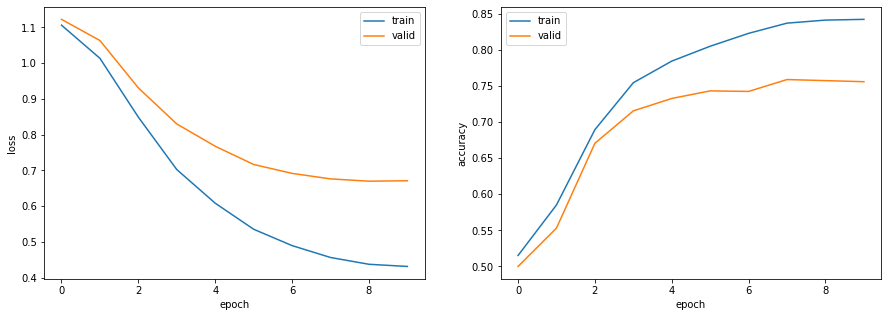

accuracy (train): 0.842
accuracy (valid): 0.763


In [15]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'accuracy (train): {acc_train:.3f}')
print(f'accuracy (valid): {acc_test:.3f}')

## 84. 単語ベクトルの導入

In [17]:
from gensim.models import KeyedVectors

keyed_vec = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin.gz', binary=True)

VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id_dict.keys()):
  if word in keyed_vec:
    weights[i] = keyed_vec[word]
    words_in_pretrained += 1
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9164 / 9394
torch.Size([9394, 300])


In [23]:
class RNN_mod1(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden(x.device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, device):
        hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=device)
        return hidden

In [24]:
class Padsequence():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}

In [25]:
VOCAB_SIZE = len(set(word2id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN_mod1(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1689, accuracy_train: 0.4165, loss_valid: 1.1732, accuracy_valid: 0.3997, 8.5335sec
epoch: 2, loss_train: 1.1746, accuracy_train: 0.4028, loss_valid: 1.1779, accuracy_valid: 0.3915, 8.3217sec
epoch: 3, loss_train: 1.2259, accuracy_train: 0.3995, loss_valid: 1.2236, accuracy_valid: 0.3975, 8.2413sec
epoch: 4, loss_train: 1.2160, accuracy_train: 0.4053, loss_valid: 1.2115, accuracy_valid: 0.4042, 8.3749sec
epoch: 5, loss_train: 1.1094, accuracy_train: 0.5279, loss_valid: 1.1044, accuracy_valid: 0.5374, 8.6143sec
epoch: 6, loss_train: 1.0741, accuracy_train: 0.5536, loss_valid: 1.0702, accuracy_valid: 0.5666, 8.4181sec
epoch: 7, loss_train: 1.0419, accuracy_train: 0.5932, loss_valid: 1.0456, accuracy_valid: 0.5906, 8.3905sec
epoch: 8, loss_train: 1.0370, accuracy_train: 0.5870, loss_valid: 1.0373, accuracy_valid: 0.5951, 8.3540sec
epoch: 9, loss_train: 0.9395, accuracy_train: 0.6544, loss_valid: 0.9567, accuracy_valid: 0.6392, 8.3443sec
epoch: 10, loss_train: 0.946

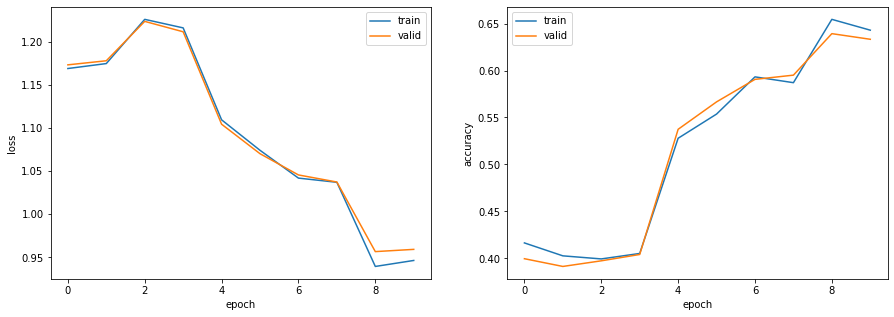

accuracy (train): 0.643
accuracy (valid): 0.638


In [28]:
visualize_logs(log)

_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'accuracy (train): {acc_train:.3f}')
print(f'accuracy (valid): {acc_test:.3f}')